# Market quota game

## Simulating SNP500 data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime, timedelta
import pandas as pd

In [5]:
r = 0.01
s = 0.1474
S0 = 100
m = r - 0.5*s*s
dt = 1/365/24/60/60/100 #10 ms
n = 100*60*1

In [6]:
def geom_brownian_motion(S0, m, s, n, dt):
    logret = np.random.normal(m * dt, s * np.sqrt(dt), size=n)
    ret = np.exp(logret.cumsum(axis=0))
    price = S0*ret
    return price

In [7]:
geom_brownian_motion(S0, m, s, (n, 3), dt).shape

(6000, 3)

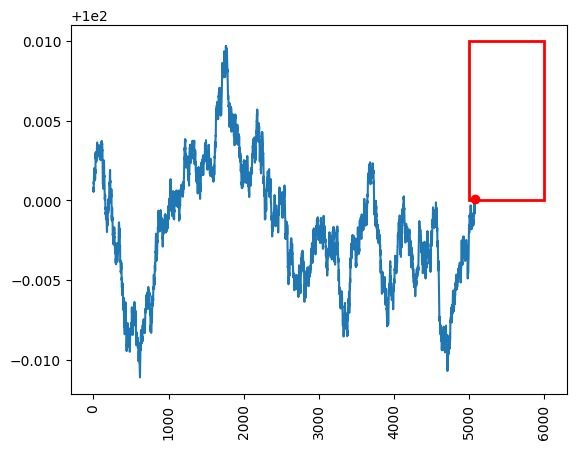

In [8]:
t = np.arange(n)
S = geom_brownian_motion(S0, m, s, n, dt)

fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.ticklabel_format(style='plain', axis='y')


rect = patches.Rectangle((5000, S0), 1000, 0.01, linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)

x0, y0, x1, y1 = rect.get_x(), rect.get_y(), rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height()

mask = (t >= x0) & (t <= x1) & (S >= y0) & (S <= y1)


hit = np.any(mask)

if hit:
    points_inside = np.column_stack((t[mask], S[mask]))
    first_x, first_y = points_inside[0]
    ax.scatter(first_x, first_y, color="red", zorder=5, label="First inside point")

    ax.plot(t[:int(first_x)], S[:int(first_x)])
else:
    ax.plot(t, S)
    

plt.show()

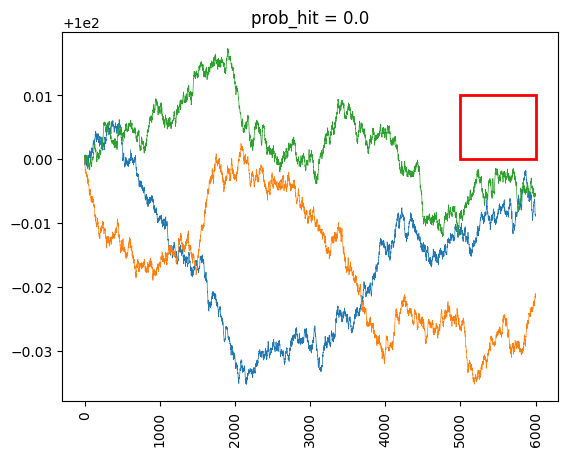

In [9]:
n_paths = 3
show_paths = 20

t = np.arange(n)
S = geom_brownian_motion(S0, m, s, (n, n_paths), dt)

fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.ticklabel_format(style='plain', axis='y')


rect = patches.Rectangle((5000, S0), 1000, 0.01, linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)

x0, y0, x1, y1 = rect.get_x(), rect.get_y(), rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height()

hits = 0
for j in range(min(S.shape[1], show_paths)):
    mask = ((t >= x0) & (t <= x1) & (S[:, j] >= y0) & (S[:, j] <= y1))
    
    hit = np.any(mask)
    
    if hit:
        first_idx = np.argmax(mask) 
        first_x, first_y = t[first_idx], S[first_idx, j]
        ax.scatter(first_x, first_y, color="red", zorder=5)
        
        ax.plot(t[:int(first_x)+1], S[:int(first_x)+1, j], linewidth=0.5)
        
        hits += 1
    else:
        ax.plot(t, S[:, j], linewidth=0.5)


prob_hit = hits / n_paths

plt.title(f"{prob_hit = }")
plt.show()

## Fully vectorized version

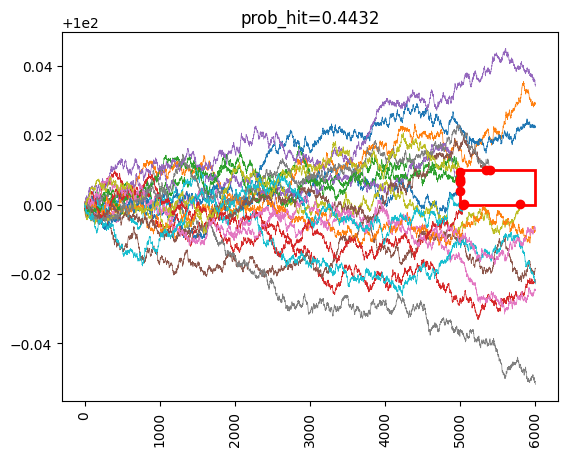

In [10]:
n_paths = 10000
show_paths = 20

n = x1

t = np.arange(n)
S = geom_brownian_motion(S0, m, s, (n, n_paths), dt)

t_broadcasted = t[:, None]  # shape (n,1)

mask = (t_broadcasted >= x0) & (t_broadcasted <= x1) & (S >= y0) & (S <= y1)

hits_mask = np.any(mask, axis=0)  # shape (n_paths,), True if path hits

hits_numeric = hits_mask.astype(float)

first_idx = np.argmax(mask, axis=0)  # shape (n_paths,)

first_idx[~hits_mask] = -1

cumsum_hits = np.cumsum(hits_numeric)

cum_prob = cumsum_hits / np.arange(1, len(hits_numeric)+1)

prob_hit = cum_prob[-1]

fig, ax = plt.subplots()
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

plt.title(f"{prob_hit = }")

rect = patches.Rectangle((x0, S0), x1-x0, 0.01, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

for j in range(min(S.shape[1], show_paths)):
    if hits_mask[j]:
        idx = first_idx[j]
        ax.plot(t[:idx+1], S[:idx+1, j], linewidth=0.5)
        ax.scatter(t[idx], S[idx, j], color="red", zorder=5)
    else:
        ax.plot(t, S[:, j], linewidth=0.5)

plt.title(f"{prob_hit=}")
plt.show()

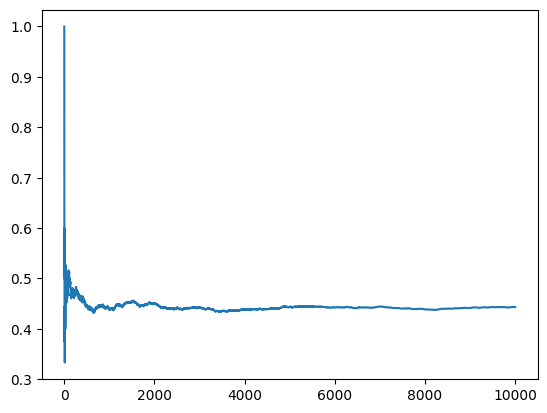

In [11]:
plt.plot(cum_prob)

$4000$ paths should be enough to estimate the probability

In [12]:
np.arange(n)

array([   0,    1,    2, ..., 5997, 5998, 5999])

## Testing the speed of the simulation

In [13]:
from datetime import datetime

n_paths = 4_000

for _ in range(10):
    t = np.arange(n)
    S = geom_brownian_motion(S0, m, s, (n, n_paths), dt)
    
    start_time = datetime.now()
    t_broadcasted = t[:, None]  # shape (n,1)

    mask = (t_broadcasted >= x0) & (t_broadcasted <= x1) & (S >= y0) & (S <= y1)

    hits_mask = np.any(mask, axis=0)  # shape (n_paths,), True if path hits

    first_idx = np.argmax(mask, axis=0)  # shape (n_paths,)

    first_idx[~hits_mask] = -1

    prob_hit = np.mean(hits_mask)
    
    duration = datetime.now() - start_time

    quota = 1 / prob_hit
    print(f"{prob_hit = }, {quota = } calculated in {duration}")

prob_hit = 0.43, quota = 2.3255813953488373 calculated in 0:00:00.347947
prob_hit = 0.43675, quota = 2.289639381797367 calculated in 0:00:00.232460
prob_hit = 0.4275, quota = 2.3391812865497075 calculated in 0:00:00.226974
prob_hit = 0.44525, quota = 2.2459292532285233 calculated in 0:00:00.268357
prob_hit = 0.44675, quota = 2.238388360380526 calculated in 0:00:00.249062
prob_hit = 0.43075, quota = 2.321532211259431 calculated in 0:00:00.278310
prob_hit = 0.433, quota = 2.3094688221709005 calculated in 0:00:00.307211
prob_hit = 0.435, quota = 2.2988505747126435 calculated in 0:00:00.229249
prob_hit = 0.4375, quota = 2.2857142857142856 calculated in 0:00:00.275022
prob_hit = 0.42525, quota = 2.3515579071134627 calculated in 0:00:00.221611


Average time seems to be around 200 ms (too long for real time calculation)

Only $1000$ paths

In [14]:
from datetime import datetime

n_paths = 1_000

for _ in range(10):
    t = np.arange(n)
    S = geom_brownian_motion(S0, m, s, (n, n_paths), dt)
    
    start_time = datetime.now()
    t_broadcasted = t[:, None]  # shape (n,1)

    mask = (t_broadcasted >= x0) & (t_broadcasted <= x1) & (S >= y0) & (S <= y1)

    hits_mask = np.any(mask, axis=0)  # shape (n_paths,), True if path hits

    first_idx = np.argmax(mask, axis=0)  # shape (n_paths,)

    first_idx[~hits_mask] = -1

    prob_hit = np.mean(hits_mask)

    duration = datetime.now() - start_time
    
    quota = 1 / prob_hit
    print(f"{prob_hit = }, {quota = } calculated in {duration}")

prob_hit = 0.446, quota = 2.242152466367713 calculated in 0:00:00.023501
prob_hit = 0.436, quota = 2.293577981651376 calculated in 0:00:00.029573
prob_hit = 0.435, quota = 2.2988505747126435 calculated in 0:00:00.024875
prob_hit = 0.445, quota = 2.247191011235955 calculated in 0:00:00.034669
prob_hit = 0.444, quota = 2.2522522522522523 calculated in 0:00:00.018045
prob_hit = 0.461, quota = 2.1691973969631237 calculated in 0:00:00.020654
prob_hit = 0.397, quota = 2.5188916876574305 calculated in 0:00:00.023552
prob_hit = 0.411, quota = 2.4330900243309004 calculated in 0:00:00.027495
prob_hit = 0.455, quota = 2.1978021978021975 calculated in 0:00:00.027546
prob_hit = 0.45, quota = 2.2222222222222223 calculated in 0:00:00.031205


Results not very accurate and computation still takes longer than 10 ms

# Using Probability theory

In [20]:
from scipy.stats import norm
from scipy.integrate import quad

In [46]:
x1, s1, x2, s2 = rect.get_x(), rect.get_y(), rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height()

t1, t2 = x1 * dt, x2 * dt
t1

1.5854895991882293e-06

In [47]:
L = (np.log(s2/S0) - m*t1)/(s * np.sqrt(t1))
P1 = norm.cdf(L) - norm.cdf((np.log(s1/S0) - m*t1)/(s * np.sqrt(t1)))
P1

0.20497497822822675

In [55]:
z = lambda w: S0*np.exp(m * t1 + s * np.sqrt(t1) * w)
def integrand_P2(w):
    return 1/np.sqrt(2*np.pi) * np.exp(-w**2/2) * (
        norm.cdf((np.log(s2/z(w)) - m*(t2 - t1))/(s * np.sqrt(t2 - t1))) + 
        np.exp(2*m*np.log(s2/z(w))/(s**2)) * norm.cdf((np.log(s2/z(w)) + m*(t2 - t1))/(s * np.sqrt(t2 - t1)))
        )

In [ ]:
P2, error = quad(integrand_P2, L, np.inf)
P2

0.10130945098077893

In [59]:
def integrand_P3(w):
    return 1/np.sqrt(2*np.pi) * np.exp(-w**2/2) * (
        1 - norm.cdf((np.log(s1/z(w)) - m*(t2 - t1))/(s * np.sqrt(t2 - t1))) + 
        np.exp(2*m*np.log(s1/z(w))/(s**2)) * norm.cdf(-(np.log(s1/z(w)) + m*(t2 - t1))/(s * np.sqrt(t2 - t1)))
        )

In [62]:
P3, error = quad(integrand_P3, -np.inf, (np.log(s2/S0) - m*t1)/(s*np.sqrt(t1)))
P3

0.4250808244630341

In [63]:
P = P1 + P2 + P3
P

0.7313652536720398